# **Voilence Detection Model**
A Deep Learning model that can detect in Violence in Videos and Live Feeds
#### By Aryan Mathur

###Models And Their Accuracy:
####MobileNet Bi LSTM : 97%
####DeVTr : 96%
####YoloV8 : 91%
####Temperal Fusion CNN +LSTM : 91%
####CNN+LTSM : 89%
####ResNet50v2 : 86.6 &
####Inception V3: 78%


WIll be going with MobileNet Bi LTSM with 16FPS analysis


Mount The Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Required Libraries


In [8]:
import importlib.util
import subprocess

def import_or_install(package):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        subprocess.check_call(['pip', 'install', package])
    finally:
        globals()[package] = importlib.import_module(package)

# List of required modules
required_modules = [
    "os", "shutil", "cv2", "math", "random", "numpy", "datetime", "tensorflow",
    "keras", "collections", "matplotlib", "decimal", "sklearn"
]

# Check and install required modules
for module in required_modules:
    import_or_install(module)

# Additional imports
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from IPython.display import HTML
from base64 import b64encode

# Additional imports (repeated imports removed)
from IPython.display import HTML
from base64 import b64encode
import mimetypes



os is already installed.
shutil is already installed.
cv2 is already installed.
math is already installed.
random is already installed.
numpy is already installed.
datetime is already installed.
tensorflow is already installed.
keras is already installed.
collections is already installed.
matplotlib is already installed.
decimal is already installed.
sklearn is already installed.


Data Visualisation

In [9]:
def play_video(filepath):
    try:
        with open(filepath, 'rb') as file:
            video_data = file.read()

        mime_type, _ = mimetypes.guess_type(filepath)
        if mime_type is None:
            raise ValueError("Cannot determine MIME type of the video file.")

        video_base64 = b64encode(video_data).decode()

        html = f'<video controls autoplay loop><source src="data:{mime_type};base64,{video_base64}" type="{mime_type}"></video>'

        return HTML(html)
    except Exception as e:
        return f"Error playing video: {e}"


In [10]:
class VideoDirectories:
    def __init__(self, non_violence_dir, violence_dir):
        self.non_violence_dir = non_violence_dir
        self.violence_dir = violence_dir

    def retrieve_video_files(self):
        non_violence_files = []
        violence_files = []

        for directory, files_list in [(self.non_violence_dir, non_violence_files), (self.violence_dir, violence_files)]:
            if not os.path.isdir(directory):
                print(f"Error: Directory '{directory}' does not exist.")
                return None, None

            files_list = os.listdir(directory)
            if not files_list:
                print(f"Warning: No video files found in '{directory}'.")

        return non_violence_files, violence_files

# Define directories
non_violence_videos_dir = "/content/drive/MyDrive/archive/real life violence situations/Real Life Violence Dataset/NonViolence/"
violence_videos_dir = "/content/drive/MyDrive/archive/real life violence situations/Real Life Violence Dataset/Violence/"

# Create an instance of VideoDirectories
video_dirs = VideoDirectories(non_violence_videos_dir, violence_videos_dir)

# Retrieve video files
non_violence_files_list, violence_files_list = video_dirs.retrieve_video_files()

if non_violence_files_list is not None and violence_files_list is not None:
    print("Non-violence video files:", non_violence_files_list)
    print("Violence video files:", violence_files_list)


Non-violence video files: []
Violence video files: []


In [11]:

def select_random_video(video_list):

    if not video_list:
        print("Warning: Empty list. Cannot select a random video.")
        return None
    else:
        return random.choice(video_list)

# Randomly select videos (assuming non-empty lists)
random_non_violence_video = select_random_video(non_violence_files_list)
random_violence_video = select_random_video(violence_files_list)

# Display selected videos
if random_non_violence_video:
    print("Random Non-violence Video:", random_non_violence_video)
if random_violence_video:
    print("Random Violence Video:", random_violence_video)


Playing Random Non Voilence Video

Playing a random Voilence Video

#Frame Extraction


In [12]:

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16


In [13]:
import cv2

def frames_extraction(video_path, sequence_length, image_height, image_width):
    """
    Extracts frames from a video file.

    Args:
    video_path (str): Path to the video file.
    sequence_length (int): Number of frames to extract.
    image_height (int): Height of the resized frames.
    image_width (int): Width of the resized frames.

    Returns:
    list: List of extracted frames.
    """
    frames_list = []

    try:
        # Read the Video File
        video_reader = cv2.VideoCapture(video_path)

        # Get the total number of frames in the video.
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count / sequence_length), 1)

        # Iterate through the Video Frames.
        for frame_counter in range(sequence_length):
            # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

            # Reading the frame from the video.
            success, frame = video_reader.read()

            if not success:
                break

            # Resize the Frame to fixed height and width.
            resized_frame = cv2.resize(frame, (image_height, image_width))

            # Normalize the resized frame
            normalized_frame = resized_frame / 255.0

            # Append the normalized frame into the frames list
            frames_list.append(normalized_frame)
    except Exception as e:
        print(f"Error extracting frames: {e}")
    finally:
        # Release the video capture object
        video_reader.release()

    return frames_list


#DataSet Preparation

In [14]:
import os
import numpy as np

def create_dataset(dataset_dir, classes_list, sequence_length, frames_extraction):
    features = []
    labels = []
    video_files_paths = []

    for class_name in classes_list:
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"Error: Directory '{class_dir}' does not exist.")
            continue

        # Retrieve video file lists
        video_files_list = os.listdir(class_dir)

        for file_name in video_files_list:
            video_file_path = os.path.join(class_dir, file_name)

            # Extract frames of the video file
            frames = frames_extraction(video_file_path, sequence_length)

            if len(frames) == sequence_length:
                features.append(frames)
                labels.append(classes_list.index(class_name))
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths


In [15]:


# Define the path to the mounted drive directory
mounted_drive_path = "/content/drive/MyDrive"

# Load data from the mounted drive
features = np.load(f"{mounted_drive_path}/features.npy")
labels = np.load(f"{mounted_drive_path}/labels.npy")
video_files_paths = np.load(f"{mounted_drive_path}/video_files_paths.npy")


Encoding and splitting DataSet


In [16]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [17]:
from sklearn.model_selection import train_test_split

# Split the Data into Train ( 80% ) and Test Set ( 20% )
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2,
                                                                            shuffle=True, random_state=42)

# Split the training data into Train ( 90% ) and Validation Set ( 10% )
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.1,
                                                                                        shuffle=True, random_state=42)


In [18]:
print(features_train.shape,labels_train.shape )
print(features_val.shape, labels_test.shape)
print(features_test.shape, labels_test.shape)


(1439, 16, 64, 64, 3) (1439, 2)
(160, 16, 64, 64, 3) (400, 2)
(400, 16, 64, 64, 3) (400, 2)


##Importing MobileNet and Finetuning it

In [19]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 60 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-60]:
  layer.trainable=False

mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[

Finding the best dropout rate

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define dropout rates to experiment with
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

# Dictionary to store validation accuracies for each dropout rate
val_accuracies = {}

for dropout_rate in dropout_rates:
    # Split dataset into train and test sets
    features_train, features_val, labels_train, labels_val = split_data(features, labels)

    # Create model with current dropout rate
    model = create_model(dropout_rate)

    # Train model
    history = model.fit(features_train, labels_train, validation_data=(features_val, labels_val), epochs=100, batch_size=32, verbose=1,
                        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    # Evaluate model on validation set
    val_loss, val_accuracy = model.evaluate(features_val, labels_val, verbose=0)

    # Store validation accuracy for current dropout rate
    val_accuracies[dropout_rate] = val_accuracy

    # Plot learning curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Model Training and Validation Loss (Dropout={dropout_rate})')
    plt.legend()
    plt.show()

# Print validation accuracies for different dropout rates
for dropout_rate, val_accuracy in val_accuracies.items():
    print(f'Dropout Rate: {dropout_rate}, Validation Accuracy: {val_accuracy}')

# Plot validation accuracies for different dropout rates
plt.bar(val_accuracies.keys(), val_accuracies.values())
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Dropout Rates')
plt.show()


NameError: name 'split_data' is not defined

##Building The Model

In [22]:
SEQUENCE_LENGTH=16
def create_model():

    model = Sequential()

    ########################################################################################################################

    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))

    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))


    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))

    model.add(Dropout(0.3))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))


    model.summary()

    return model


# **Model Construction**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

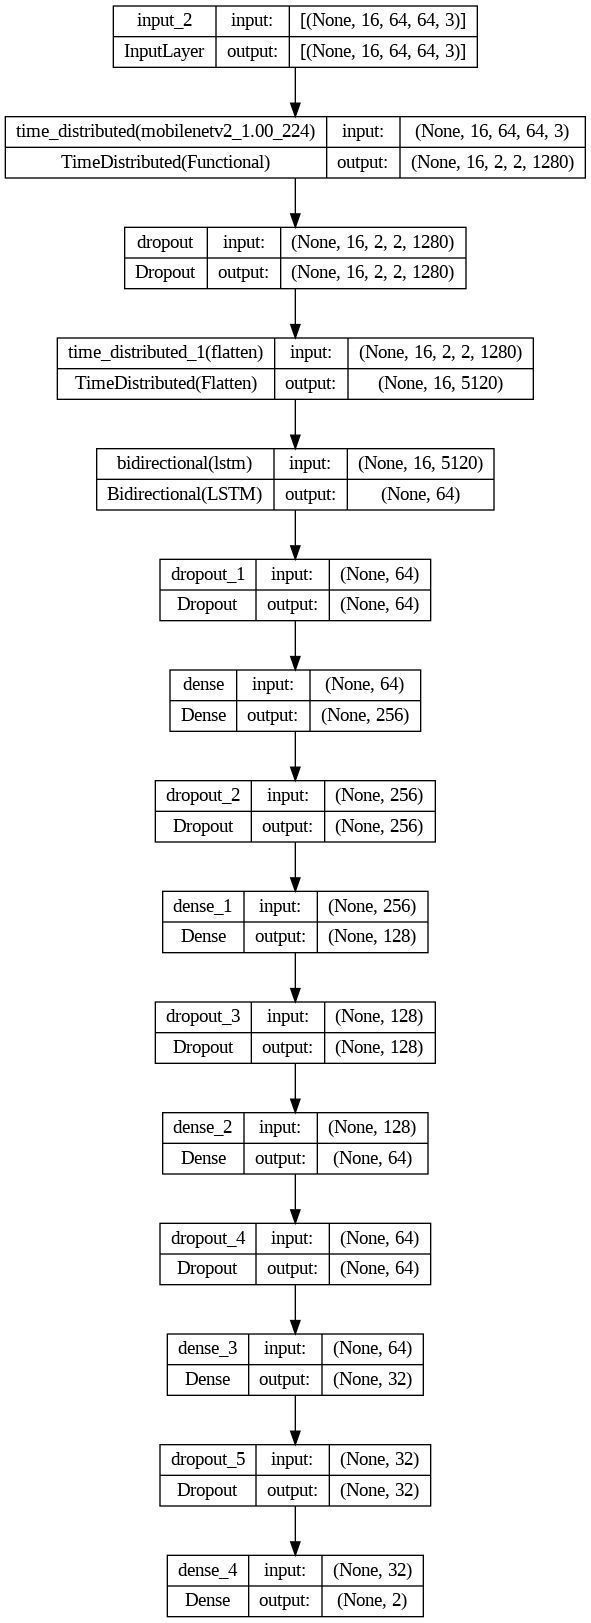

In [23]:
from keras.utils import plot_model

# Define CLASSES_LIST
CLASSES_LIST = ["NonViolence", "Violence"]

# Create and compile the model
aryxn_model = create_model()
aryxn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Plot the structure of the constructed aryxn model
plot_model(aryxn_model, to_file='aryxn_model_structure_plot.png', show_shapes=True, show_layer_names=True)


CallBack Specification and Fitting

In [24]:
import tensorflow as tf

# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Define Reduce Learning Rate on Plateau Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

# Compile the model
aryxn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fit the model
history = aryxn_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8,
                           shuffle=True, validation_data=(features_val, labels_val), callbacks=[early_stopping, reduce_lr])


Epoch 1/50
180/180 [==============================] - 35s 91ms/step - loss: 0.6975 - accuracy: 0.5010 - val_loss: 0.6939 - val_accuracy: 0.4812 - lr: 0.0100
Epoch 2/50
180/180 [==============================] - 12s 68ms/step - loss: 0.6952 - accuracy: 0.5212 - val_loss: 0.6903 - val_accuracy: 0.4875 - lr: 0.0100
Epoch 3/50
180/180 [==============================] - 12s 68ms/step - loss: 0.6856 - accuracy: 0.5400 - val_loss: 0.6692 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 4/50
180/180 [==============================] - 12s 69ms/step - loss: 0.6650 - accuracy: 0.5935 - val_loss: 0.5904 - val_accuracy: 0.7937 - lr: 0.0100
Epoch 5/50
180/180 [==============================] - 12s 68ms/step - loss: 0.5671 - accuracy: 0.7248 - val_loss: 0.4208 - val_accuracy: 0.8500 - lr: 0.0100
Epoch 6/50
180/180 [==============================] - 12s 68ms/step - loss: 0.4701 - accuracy: 0.8054 - val_loss: 0.3597 - val_accuracy: 0.8375 - lr: 0.0100
Epoch 7/50
180/180 [==============================] - 12s 

In [25]:
# Evaluate the model on the test set
model_evaluation_history = aryxn_model.evaluate(features_test, labels_test)

# Specify the path in your Google Drive
save_path = '/content/drive/MyDrive/aryxn'

# Save the model to Google Drive
aryxn_model.save(save_path)


13/13 [==============================] - 5s 141ms/step - loss: 0.2266 - accuracy: 0.9350


Model Evaluation

In [26]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    """
    Plot two metrics from model training history.

    Args:
    - model_training_history (History): History object returned by model.fit()
    - metric_name_1 (str): Name of the first metric to plot
    - metric_name_2 (str): Name of the second metric to plot
    - plot_name (str): Title of the plot

    Returns:
    - None
    """

    # Extract metric values from training history
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the number of epochs
    epochs = range(1, len(metric_value_1) + 1)

    # Plot the metrics
    plt.plot(epochs, metric_value_1, 'b', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)

    # Set plot title and legend
    plt.title(plot_name)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()

    # Show plot
    plt.show()


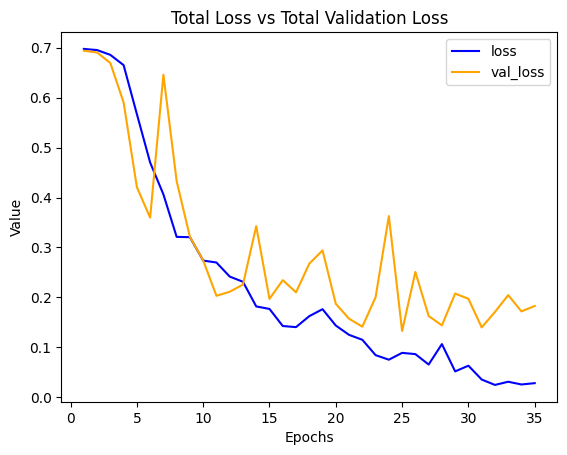

In [27]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


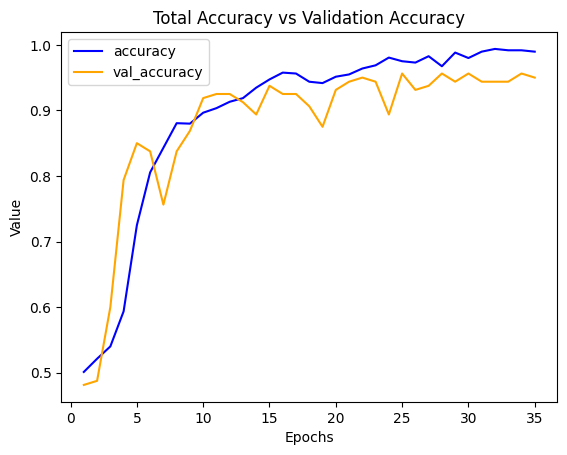

In [28]:
# Example usage of the plot_metric function with the new model's training history
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Validation Accuracy')


In [29]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Calculate precision
precision = precision_score(y_true, y_pred)

# Calculate sensitivity (recall)
sensitivity = recall_score(y_true, y_pred)

# Calculate specificity
specificity = specificity_score(y_true, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Precision:", precision)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


NameError: name 'y_true' is not defined

##Predicting The Test Set

In [30]:
labels_predict = aryxn_model.predict(features_test)


13/13 [==============================] - 3s 60ms/step


In [31]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [32]:
labels_test_normal.shape , labels_predict.shape

((400,), (400,))

Accuracy Score


In [33]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score.
accuracy = accuracy_score(labels_test_normal, labels_predict)

# Print the accuracy score.
print('Accuracy Score:', accuracy)


Accuracy Score: 0.935


Confusion Matrix

Precision: 0.9326424870466321
Sensitivity (Recall): 0.9326424870466321
Specificity: 0.9371980676328503
Confusion Matrix:


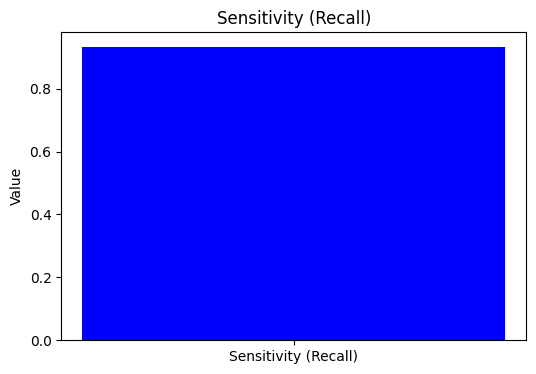

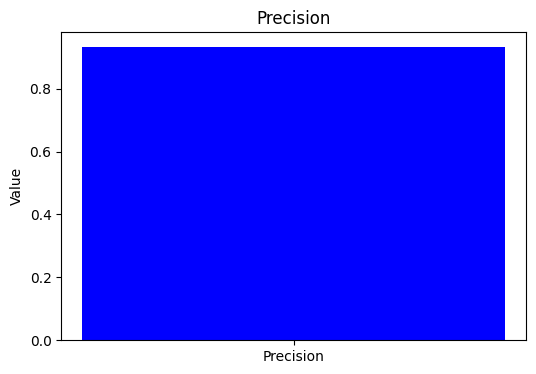

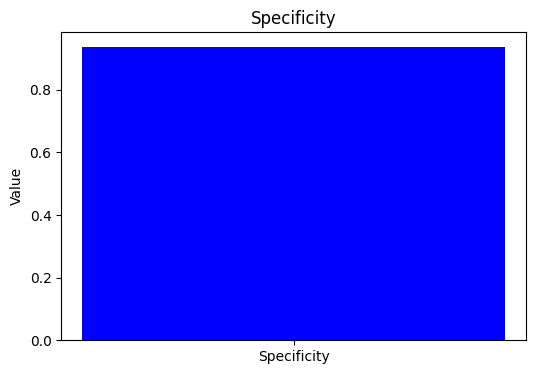

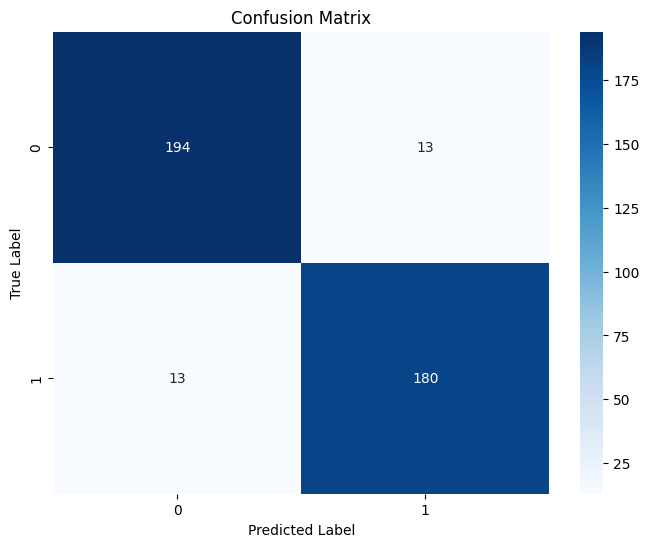

In [39]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

def plot_metrics(y_true, y_pred, plot_title):
    """
    Plot sensitivity, precision, specificity, and confusion matrix.

    Args:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - plot_title (str): Title of the plot.

    Returns:
    - None
    """

    # Calculate precision
    precision = precision_score(y_true, y_pred)

    # Calculate sensitivity (recall)
    sensitivity = recall_score(y_true, y_pred)

    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Precision:", precision)
    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("Confusion Matrix:")

    # Visualize sensitivity
    plt.figure(figsize=(6, 4))
    plt.bar(['Sensitivity (Recall)'], [sensitivity], color='blue')
    plt.title('Sensitivity (Recall)')
    plt.ylabel('Value')
    plt.show()

    # Visualize precision
    plt.figure(figsize=(6, 4))
    plt.bar(['Precision'], [precision], color='blue')
    plt.title('Precision')
    plt.ylabel('Value')
    plt.show()

    # Visualize specificity
    plt.figure(figsize=(6, 4))
    plt.bar(['Specificity'], [specificity], color='blue')
    plt.title('Specificity')
    plt.ylabel('Value')
    plt.show()

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example usage
plot_metrics(labels_test_normal, labels_predict, 'Model Evaluation Metrics')



Classification Report

In [40]:
from sklearn.metrics import classification_report
# Generate classification report for model evaluation.

ClassificationReport = classification_report(labels_test_normal,labels_predict)
# Print the classification report.

print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       207
           1       0.93      0.93      0.93       193

    accuracy                           0.94       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.94      0.94      0.94       400

